# On Parcels
> An introductory article to Cryptovoxels' Parcel Data

- toc: true
- filename: Parcels
- tab: CVMinigames | Parcels
- title: CVMinigames
- template: article
- description: this isnt working
- image: images/company_logo.png
- keywords: thisworks
- badges: true
- comments: true
- categories: [test]
- hide: false
- metadata_key1: metadata_value1
- metadata_key2: metadata_value2

Lets explore voxels data!

## Parcel Data

In [ ]:
#hide 
!pip install matplotlib  
!pip install requests

For starters CV provides generic data on ALL their [parcels](https://www.cryptovoxels.com/api/parcels/search.json).

In [18]:
#hide 
import requests
import json
url = 'https://www.cryptovoxels.com/api/parcels/search.json'
r = requests.get(url)
data = json.loads(r.text)['parcels'] 
parcels = pd.DataFrame.from_dict(data)
parcels.head(1)

,id,height,address,suburb,island,name,geometry,area,distance,owner,owner_name,x1,x2,y1,label,y2,z1,z2
0,7421,6,2b Gacrux Ave,Milky Way,Andromeda,None,"{'type': 'Polygon', 'crs': {'type': 'name', 'p...",585,5891.126151,0xf897a887ddd26899f7da140b30459e5bc4ddc9bc,sukoneck.eth,-5581,-5566,8,None,6,1930,1969


The data contains geocoordinates and a bit of meta data which can let us do fun stuff like creating this <a href="https://cvminigames.com/blog/docs/maps/cv_price_map.html"> map </a>.

We can do other things. 

Here is a frequency plot of Flora Islands Area

<AxesSubplot:ylabel='Frequency'>

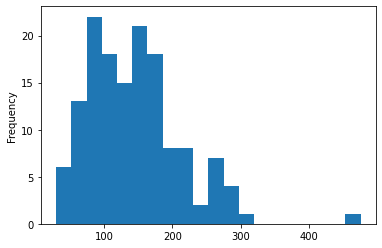

In [22]:
#hide_input 
parcels[parcels['island'] == 'Flora']['area'].plot.hist(bins=20)

## Filtering Parcels

Information about a specific parcel is available by adding it's parcel number + .json to the end of the following url: https://www.cryptovoxels.com/api/parcels/  

This data can then be filtered en-mass to search for certain properties, or inspected individually.

For example, here is a [map](https://cvminigames.com/blog/docs/maps/cv_book_map.html) of all the guestbooks!